## Predict historical prices of Brent Oil, Crude Oil WTI, Natural Gas, Heating Oil from 2000-2022 with Fedot.Industrial

Dataset published on Kaggle3 consists of historical prices of Brent Oil, CrudeOil WTI, Natural Gas, and Heating Oil from 2000 to 2022. This sample of DailyOilGasPrices was created by using 30 consecutive business days of **Crude Oil WTI close prices** and **traded volumes** as **predictors** and the **average natural gas close** price during each 30-day time frame as the **target** variable. The final dataset has 191 2-dimensional time series of length 30, of which 70% were randomly sampled as training data and the remaining 30% as testing data. This type of model could help companies and governments to better analyse and predict economic situations and correlations regarding oil and natural gas.
Link to the dataset - https://www.kaggl.com/datasets/prasertk/historical-daily-oil-and-natural-gas-prices

In [1]:
import pandas as pd
from fedot_ind.api.main import FedotIndustrial

In [2]:
def evaluate_loop(train_data, api_params, finetune: bool = False):
    industrial = FedotIndustrial(**api_params)
    if finetune:
        industrial.finetune(train_data)
    else:
        industrial.fit(train_data)
    return industrial

In [3]:
from fedot_ind.api.utils.path_lib import PROJECT_PATH

dataset_name = PROJECT_PATH +'/examples/data/forecasting\monash_benchmark\MonashFredMd_12.csv'
horizon = 12
metric_names = ('smape', 'rmse', 'median_absolute_error')
train_data = pd.read_csv(dataset_name)
params = dict(problem='ts_forecasting',
                             metric='rmse',
                             timeout=15,
                             pop_size = 10,
                             with_tuning = False,
                             task_params={'forecast_length': horizon},
                             industrial_strategy='forecasting_assumptions',
                             n_jobs=2,
                             logging_level=50)

In [4]:
train_data

,datetime,value,label
0,1959-01-01,2437.295898,T1
1,1959-02-01,2446.902100,T1
2,1959-03-01,2462.688965,T1
3,1959-04-01,2478.743896,T1
4,1959-05-01,2493.228027,T1
...,...,...,...
77891,2019-04-01,3608.839111,T107
77892,2019-05-01,3622.253174,T107
77893,2019-06-01,3651.351318,T107
77894,2019-07-01,3673.951416,T107


Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [5]:
id_list = train_data['label'].unique().tolist()
data_split = {id:train_data[train_data['label']==id]['value'].values for id in id_list}

Lets check our data.

Lets visualise our predictors.

In [ ]:
from matplotlib import pyplot as plt
pd.DataFrame(train_data).plot(title='Example of FRED time series')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [ ]:
industrial_model =  evaluate_loop(train_data = input_data, api_params=params, finetune=True)

In [ ]:
labels = industrial_model.predict(train_data)
metrics = industrial_model.get_metrics(target=target,
                                         metric_names=metric_names)

In [ ]:
metrics

## AutoML approach

In [ ]:
fred_results = {}
for index, ts in data_split.items():
    input_data = (ts,ts[-horizon:].flatten())
    industrial_auto_model = evaluate_loop(train_data=input_data, api_params=params, finetune=False)
    auto_labels = industrial_auto_model.predict(input_data)
    auto_metrics = {}
    for forecat_model, predict in auto_labels.items():
        industrial_auto_model.predicted_labels = predict

        current_metric = industrial_auto_model.get_metrics(target=ts[-horizon:].flatten(),
                                                metric_names=metric_names)
        auto_metrics.update({forecat_model:current_metric})
    fred_results.update({index:(industrial_auto_model,auto_metrics)})

Creating Dask Server


Generations:   0%|          | 10/10000 [04:44<78:53:15, 28.43s/gen]


Creating Dask Server


Generations:   0%|          | 11/10000 [04:52<73:47:17, 26.59s/gen]


Creating Dask Server


Generations:   0%|          | 10/10000 [04:39<77:39:27, 27.98s/gen]


Creating Dask Server


Generations:   0%|          | 5/10000 [04:34<152:32:31, 54.94s/gen]


Creating Dask Server


Generations:   0%|          | 20/10000 [05:14<43:39:40, 15.75s/gen]


Creating Dask Server


Generations:   0%|          | 14/10000 [04:41<55:47:50, 20.12s/gen]


Creating Dask Server


Generations:   0%|          | 18/10000 [04:50<44:43:07, 16.13s/gen]


Creating Dask Server


Generations:   0%|          | 18/10000 [04:49<44:38:28, 16.10s/gen]


Creating Dask Server


Generations:   0%|          | 3/10000 [05:33<308:25:57, 111.07s/gen]


Creating Dask Server


Generations:   0%|          | 5/10000 [04:29<149:25:12, 53.82s/gen]


Creating Dask Server


Generations:   0%|          | 4/10000 [04:50<201:45:30, 72.66s/gen]


Creating Dask Server


Generations:   0%|          | 12/10000 [04:47<66:23:41, 23.93s/gen]


Creating Dask Server


Generations:   0%|          | 4/10000 [04:26<184:58:03, 66.61s/gen]


Creating Dask Server


Generations:   0%|          | 4/10000 [01:47<78:54:11, 28.42s/gen]

In [17]:
import numpy as np
border = 100
baseline = labels
ridge = auto_labels['lagged_ridge']
eigen = auto_labels['eigen_ar']
cgru = auto_labels['cgru']
plt.close()
real_values = train_data
if len(real_values) > border:
    real_values = real_values[-border:]
indicies = np.arange(real_values.shape[0])

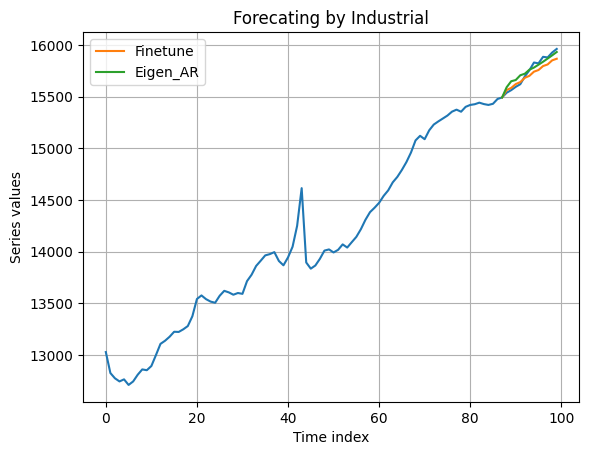

In [21]:
plt.xlabel('Time index')
plt.ylabel('Series values')
plt.title('Forecating by Industrial')
plt.plot(real_values)

real_last_value = real_values[-horizon- 1]
plt.plot(indicies[-horizon- 1:],
         np.insert(baseline, 0, real_last_value), label='Finetune')
plt.plot(indicies[-horizon- 1:],
         np.insert(eigen, 0, real_last_value), label='Eigen_AR')

plt.grid()
plt.legend()

## Compare with State of Art (SOTA) models

In [ ]:
df_sota = pd.read_csv('./Monash_forecasting_SOTA_results.csv')

In [ ]:
df_sota